In [1]:
import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym

from src import helpers
from src.definitions import PROJECT_ROOT, enforce_absolute_path

import src.lucy_classes_v1 as lucy

importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [2]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v1.xml")


def new_vec_env(env:lucy.LucyEnv, monitor_dir:str):
    return make_vec_env(
    env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=monitor_dir,
)


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(
    f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators"
)
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/lucy_v1_standing_{sim_start_time}/"
os.makedirs(log_dir, exist_ok=True)
print(f"Standing log directory: {log_dir}")




MuJoCo version: 3.4.0
Lucy model loaded: 59 qpos dims, 47 qvel dims, 19 actuators
Observation space will be: 104 dims (qpos[2:] + qvel)
Standing log directory: logs/lucy_v1_standing_2026-01-10_13-52/


Episode terminated during frame collection.


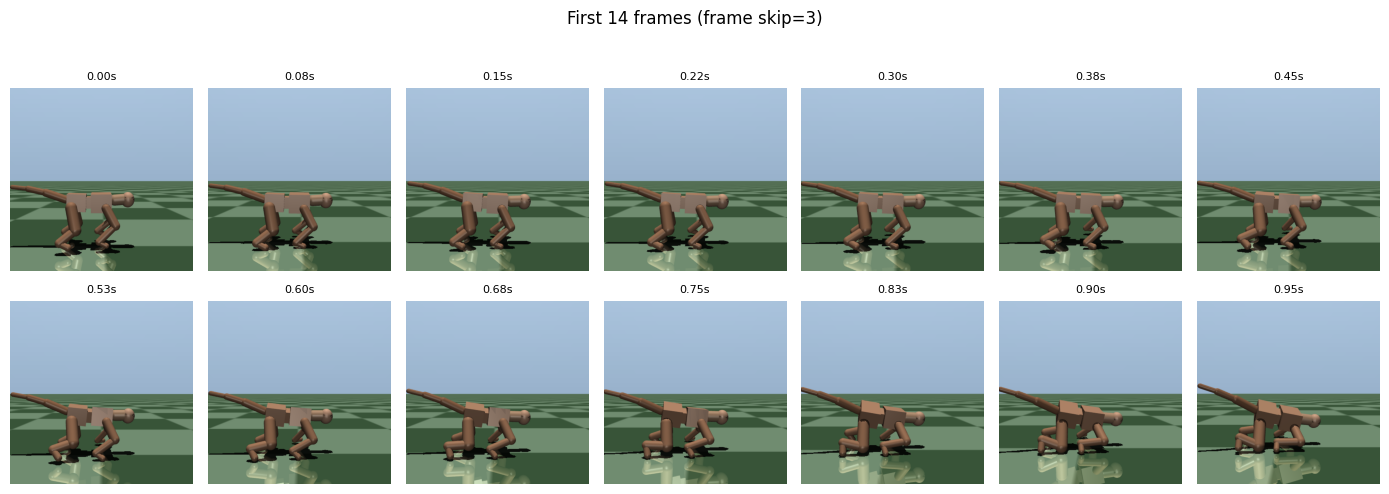

,time,chest_height,forward_velocity,total_height_reward,head_direction_reward,leg_pos_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.180509,0.087909,1.673185,0.098378,0.213746,3.545563,12.337902
2,0.150,0.180289,0.016886,1.711573,0.099732,0.212343,3.678966,23.205859
3,0.225,0.179420,0.000501,1.675546,0.097408,0.209946,3.604342,34.106131
4,0.300,0.178205,0.001873,1.635272,0.093681,0.207178,3.568945,44.781343
5,0.375,0.177198,0.019886,1.610609,0.094757,0.205308,3.545940,55.454600
6,0.450,0.172562,0.068954,1.481750,0.094330,0.201325,3.359523,65.681430
7,0.525,0.167571,0.098053,1.381437,0.094461,0.195254,3.283855,75.547243
8,0.600,0.160959,0.140013,1.260531,0.092377,0.187387,3.109086,85.107218
9,0.675,0.153175,0.107633,1.153488,0.087710,0.175270,1.002400,90.155288


In [3]:
importlib.reload(lucy)


def make_env(render_mode="None", *args, **kwargs):
    return lucy.LucyStandingWrapper(
        lucy.LucyEnv(xml_file=xml_path, render_mode=render_mode, max_episode_seconds=10),
    )


env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=[
        "chest_height",
        "forward_velocity",
        "total_height_reward",
        "head_direction_reward",
        "leg_pos_reward"
    ],
)
plt.show()
df

In [ ]:
standing_vec_env = new_vec_env(make_env, log_dir)


standing_vec_env = VecMonitor(standing_vec_env, log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {log_dir}")




standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=512,
    n_epochs=3,
    gamma=0.99,
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    learning_rate=2e-4,
    target_kl=0.02,
    policy_kwargs=dict(
        net_arch=dict(pi=[512, 512], vf=[512, 512])  # Larger network for complex body
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 800_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Created 7 parallel standing environments
Logging to: logs/lucy_v1_standing_2026-01-10_13-52/
Using cpu device
Training standing policy for 800,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51.9     |
|    ep_rew_mean     | 96.4     |
| time/              |          |
|    fps             | 1556     |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 53.2        |
|    ep_rew_mean          | 97.7        |
| time/                   |             |
|    fps                  | 1560        |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.013615774 |
|    clip_fraction        | 0.204     

In [ ]:
standing_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v1_standing_model_{sim_start_time}"
)
standing_model.save(standing_model_path)
print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_13-06


In [ ]:
importlib.reload(render_model_gym)
#render_model_gym.render_model_gym(standing_model_save_path, xml_path)

<module 'src.render_model_gym' from 'c:\\GitHub\\training-lucy\\src\\render_model_gym.py'>

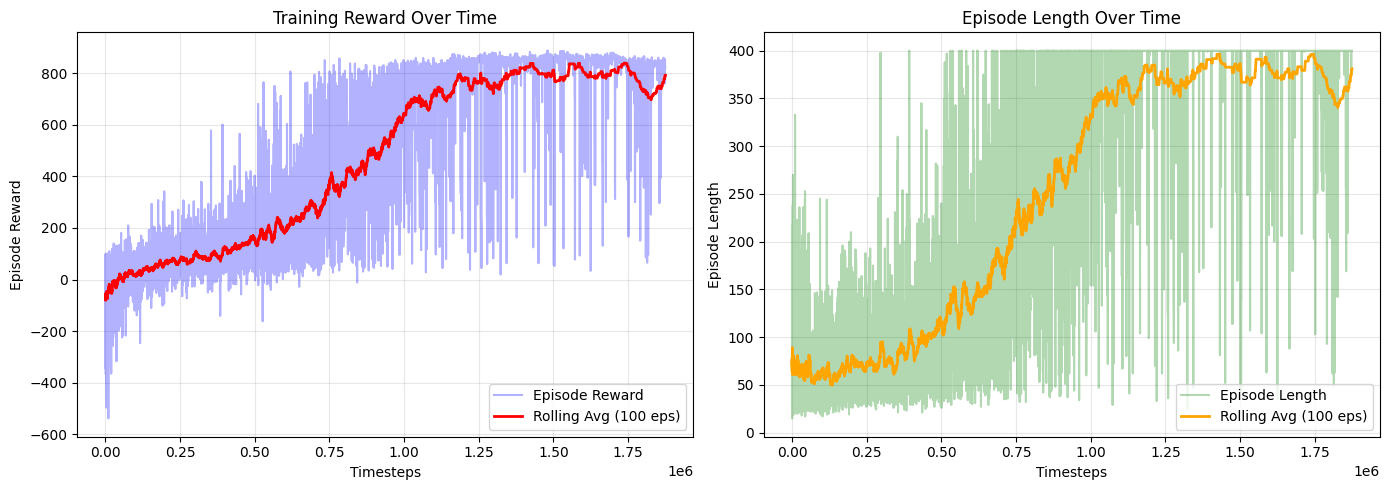

Training Summary:
Total episodes: 10272
Final avg reward (last 100 eps): 792.29
Max reward: 887.41
  Final avg length (last 100 eps): 381.1


In [ ]:
standing_df = load_results(log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\326po\AppData\Local\Temp\ipykernel_25824\4053533647.py:2: SyntaxWarning: invalid escape sequence '\G'
  standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"


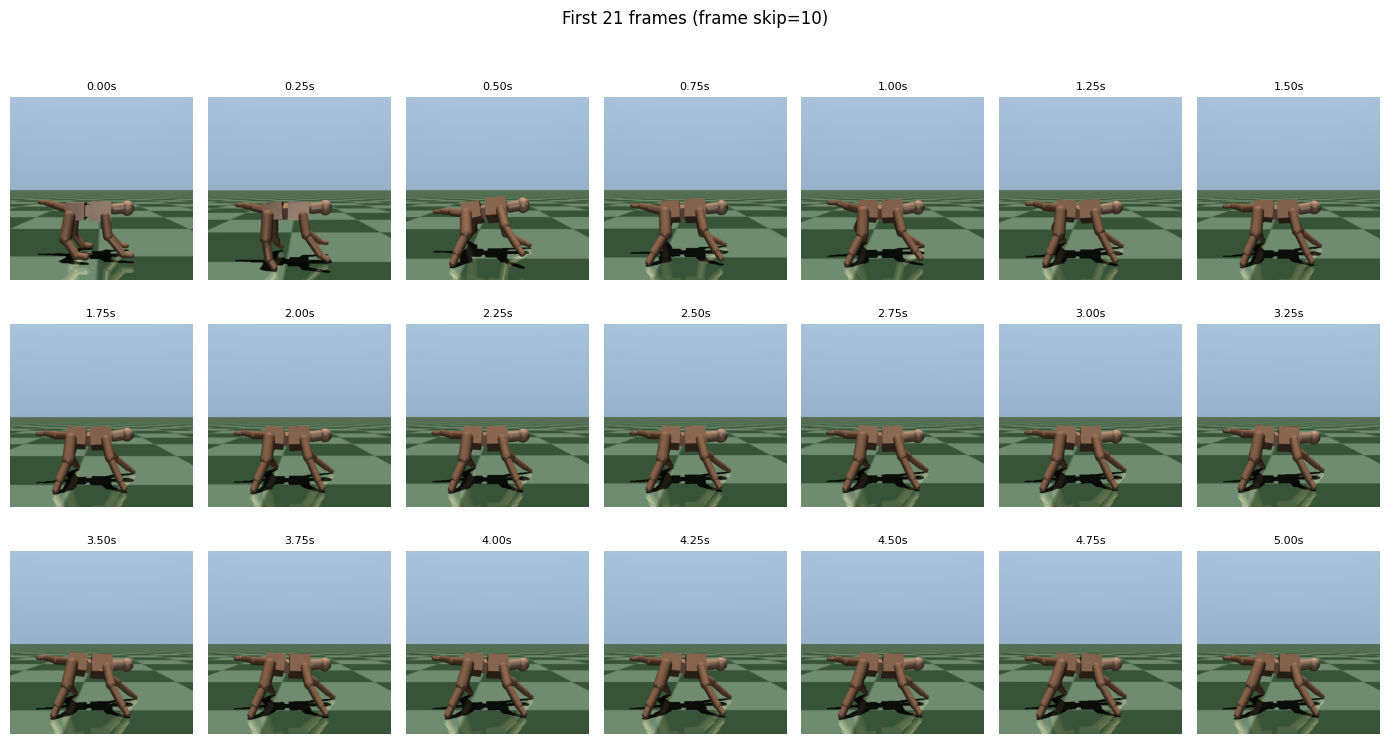

,time,chest_height,forward_velocity,height_reward,head_direction_reward,reward,cum_reward
0,0.00,NaN,NaN,None,NaN,NaN,NaN
1,0.25,0.230123,0.380778,None,0.098269,2.430828,17.980187
2,0.50,0.192428,-0.036851,None,0.096391,2.159719,40.084227
3,0.75,0.186224,0.006099,None,0.096892,2.172542,61.803052
4,1.00,0.189751,-0.029277,None,0.091611,2.281522,84.221375
5,1.25,0.190669,-0.009091,None,0.095786,2.275121,106.834931
6,1.50,0.190693,-0.011835,None,0.097240,2.292750,129.761730
7,1.75,0.188655,-0.008424,None,0.096723,2.282459,152.653155
8,2.00,0.185718,-0.005803,None,0.094094,2.256299,175.216770
9,2.25,0.182408,-0.012419,None,0.092127,2.219434,197.514753


In [ ]:

if "standing_model_path" not in locals():
    standing_model_path = "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"

    
model = PPO.load(
    standing_model_path, env=make_env()
)
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=[
        "chest_height",
        "forward_velocity",
        "height_reward",
        "head_direction_reward",
    ],
    model=model,
)
plt.show()
display(df)

# Walking training

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


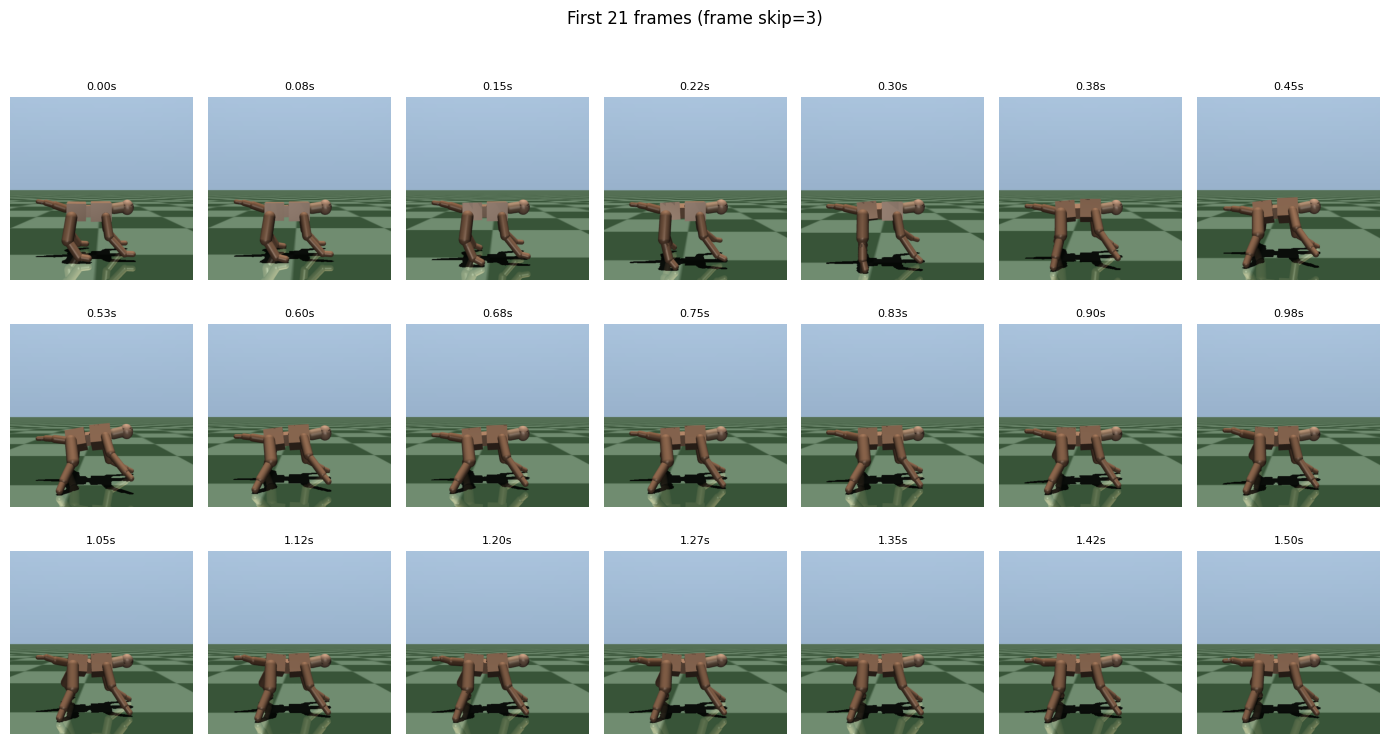

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.075,0.198689,0.069152,0.405486,0.0,-0.314784,0.087929,1.265184,2.888348
2,0.150,0.214827,0.193076,1.012555,0.0,-0.230285,0.088053,1.898567,7.876755
3,0.225,0.227854,0.311481,1.681580,0.0,-0.220000,0.083797,2.577402,14.870075
4,0.300,0.230936,0.440793,2.393260,0.0,-0.004176,0.073808,3.331806,24.122905
5,0.375,0.209213,0.525742,2.752673,0.0,-0.003301,0.061233,3.663909,35.026274
6,0.450,0.191376,-0.230213,-1.219467,-0.0,-0.034742,0.056088,-0.333462,37.151274
7,0.525,0.193298,0.022137,0.223214,0.0,-0.204041,0.055059,1.072698,38.769096
8,0.600,0.184836,0.072638,0.222975,0.0,-0.206348,0.054769,1.071725,42.706565
9,0.675,0.184775,0.020029,0.043253,0.0,-0.412932,0.056182,0.853212,45.367503


In [ ]:
# Create walking training environment
importlib.reload(lucy)

walking_attrKeys =[
    "chest_height",
    "forward_velocity",
    "forward_reward",
    "gait_reward",
    "stillness_reward",
    "leg_pos_reward",
    ]


walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=60,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=5.0,
        gait_weight=0.2,
        body_contact_penalty=-2.0,
    )
    return env



env = make_walking_env(render_mode="rgb_array")
model = PPO.load(standing_model_path, env=env)

model.set_env(env)

  # attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
df

In [ ]:
walking_vec_env = new_vec_env(make_walking_env, walking_log_dir)
print(f"Loading from standing model at: {standing_model_path}")

walking_model = PPO.load(standing_model_path, env=walking_vec_env)
walking_model.set_env(walking_vec_env)

walking_model.learn(total_timesteps=800_000)

Loading from standing model at: C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_13-06
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.07e+03 |
|    ep_rew_mean     | 923      |
| time/              |          |
|    fps             | 1622     |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.19e+03    |
|    ep_rew_mean          | 1.03e+03    |
| time/                   |             |
|    fps                  | 1584        |
|    iterations           | 2           |
|    time_elapsed         | 18          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.014858347 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|  

In [ ]:
walking_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v1_walking_model_{walking_start_time}"
)
walking_model.save(walking_model_path)

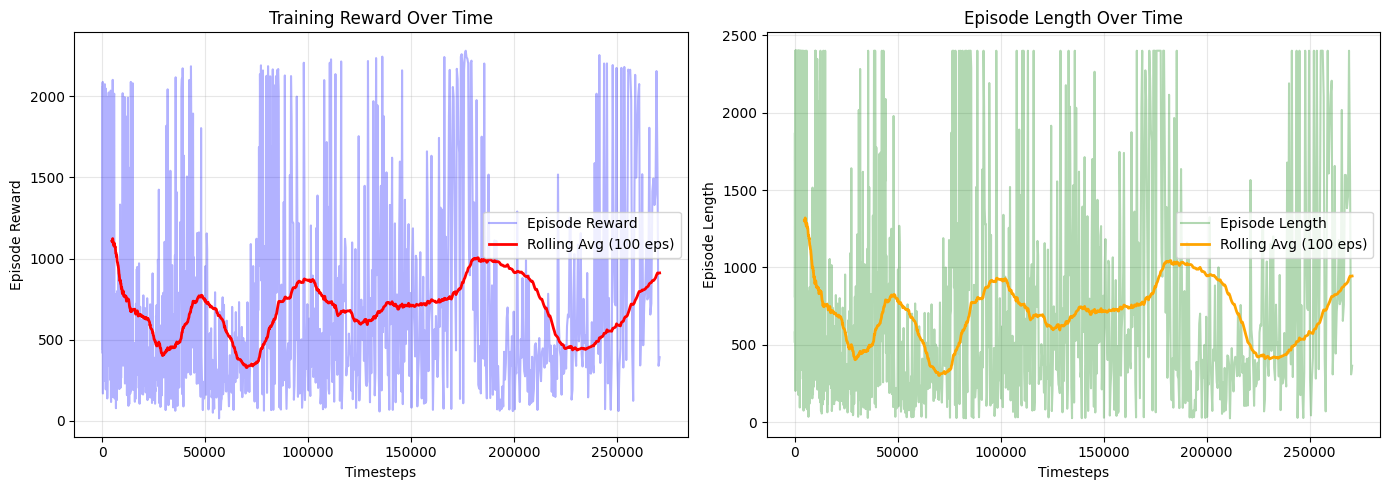

Training Summary:
Total episodes: 1052
Final avg reward (last 100 eps): 911.17
Max reward: 2280.35
  Final avg length (last 100 eps): 944.2


In [ ]:
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


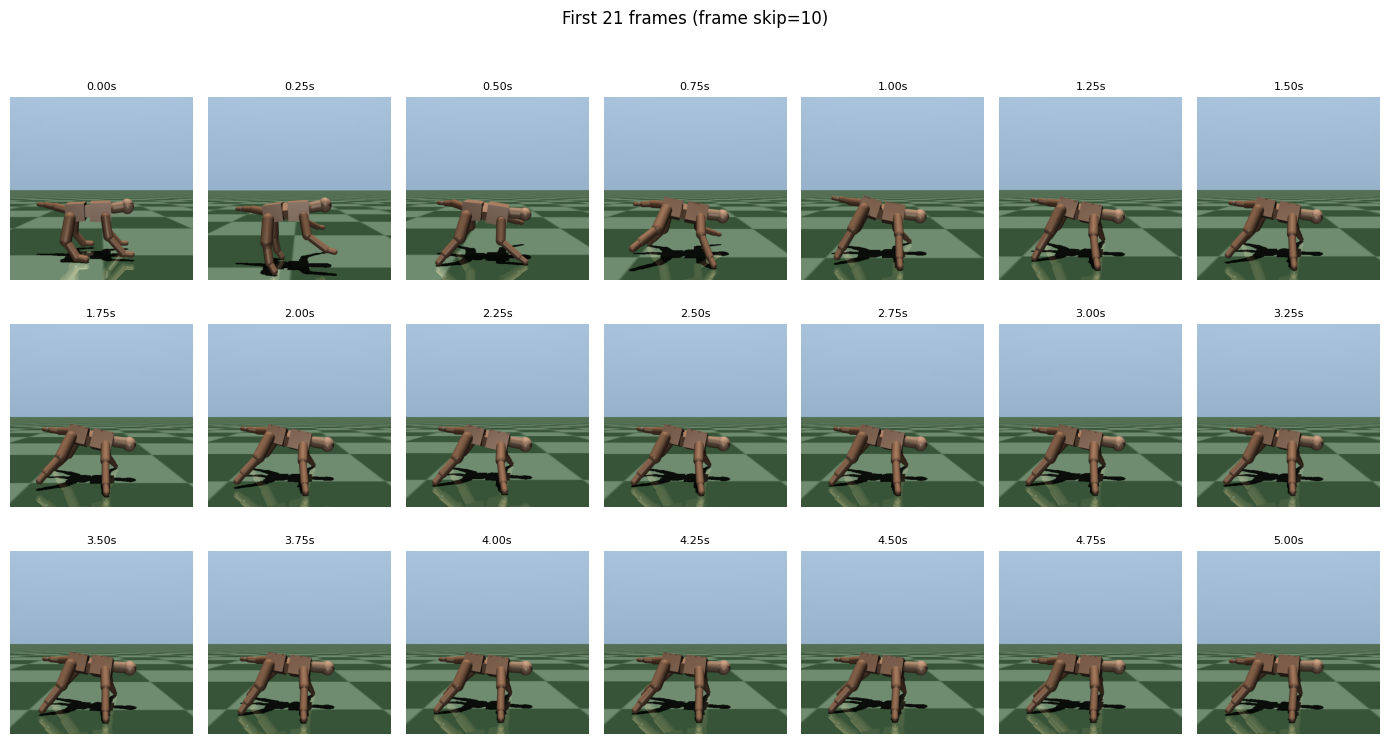

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.25,0.248906,0.361962,1.998388,0.0,-0.120081,0.076595,2.928487,17.406480
2,0.50,0.194683,0.859961,4.839020,0.0,-0.006709,0.051839,5.750170,58.947303
3,0.75,0.180472,0.246941,1.260067,0.0,-0.118052,0.049696,2.135530,78.664668
4,1.00,0.177274,-0.012742,-0.130839,-0.0,-0.231429,0.054490,0.721738,94.672093
5,1.25,0.174571,-0.012710,0.066878,0.0,-0.357101,0.053316,0.890965,104.955451
6,1.50,0.175184,0.011383,0.135568,0.0,-0.398087,0.051754,0.950222,114.064154
7,1.75,0.171298,0.011744,0.087978,0.0,-0.367974,0.050557,0.907510,123.089382
8,2.00,0.164229,0.002804,0.043384,0.0,-0.366914,0.049146,0.860435,131.778074
9,2.25,0.157849,0.002769,-0.000801,-0.0,-0.439995,0.048050,0.799894,140.390075


In [ ]:
model = PPO.load(walking_model_path, env=make_walking_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_walking_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
display(df)

In [ ]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0250s per step
Running simulation at 1.0x speed... Close the window to exit.


c:\GitHub\training-lucy\.venv\Lib\site-packages\glfw\__init__.py:917: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)
